<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/statistics/stock-price-pred/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install -q yfinance

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

# #Data viz
# import plotly.graph_objs as go

In [24]:
data = yf.download(tickers='TSLA', period='24mo', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [25]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,65.879997,67.276001,65.737999,66.973999,66.973999,30372500
2019-12-03,66.524002,67.582001,66.438004,67.239998,67.239998,32868500
2019-12-04,67.550003,67.571999,66.570000,66.606003,66.606003,27665000
2019-12-05,66.566002,66.884003,65.449997,66.073997,66.073997,18623000
2019-12-06,67.000000,67.772003,66.954002,67.178001,67.178001,38062000


In [120]:
cols = [ "Date", "Close", "Volume" ]
tsla_data = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/statistics/stock-price-pred/res/tsla_2yr_data.csv", usecols=cols)
tsla_data.head()

,Date,Close,Volume
0,2019-11-25,67.267998,61697500
1,2019-11-26,65.783997,39737000
2,2019-11-27,66.258003,27778000
3,2019-11-29,65.987999,12328000
4,2019-12-02,66.973999,30372500


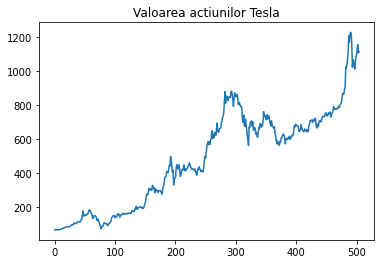

In [121]:
plt.title("Valoarea actiunilor Tesla")
plt.plot(tsla_data.Close)

In [130]:
max = tsla_data.Close.max()
real = pd.DataFrame({'value': tsla_data.Close / max})

In [132]:
real.head()

,value
0,0.054693
1,0.053487
2,0.053872
3,0.053653
4,0.054454


In [153]:
def MovingAverage(data, n):
    res = data[n:].copy()
    res.value = [ np.sum(data[i-n:i]).value / n for i in range(n, len(data)) ]
    return res

In [200]:
real

KeyError: ignored

In [202]:
real[2:] - ma2

,value
2,-0.000218
3,-0.000027
4,0.000692
5,0.000617
6,-0.000407
...,...
500,0.019928
501,0.036072
502,0.032645
503,-0.030844


In [197]:
for idx, val in real[:10].itertuples():
    print(real[idx])

KeyError: ignored

In [203]:
def ResidualError(real_data, forcast_data):
    n_diff = len(real_data) - len(forcast_data)
    return real_data[n_diff:] - forcast_data

In [ ]:
real[2:] - ma2

,value
2,-0.000218
3,-0.000027
4,0.000692
5,0.000617
6,-0.000407
...,...
500,0.019928
501,0.036072
502,0.032645
503,-0.030844


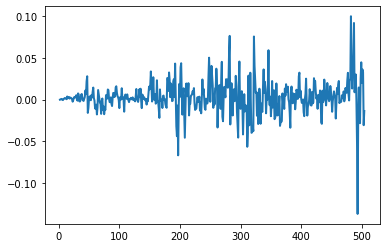

In [205]:
err = ResidualError(real, ma2)
plt.plot(err.index, err, label = "Error", linewidth=2)

In [159]:
ma2 = MovingAverage(real, 2)
ma3 = MovingAverage(real, 3)

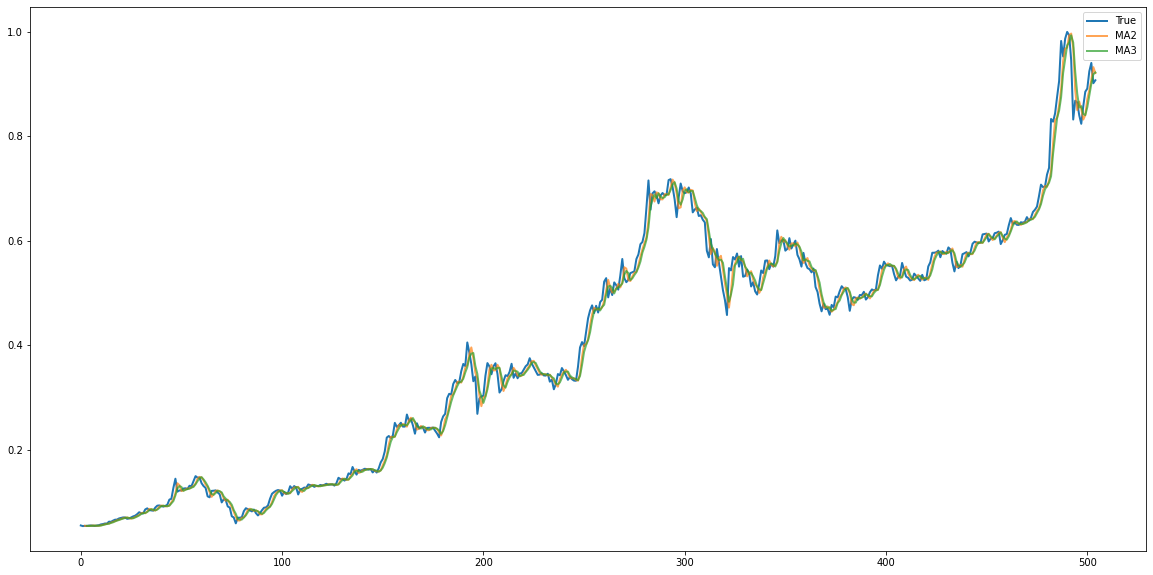

In [165]:
plt.figure(figsize=(20,10))
plt.plot(real.index, real, label = "True", linewidth=2)
plt.plot(ma2.index, ma2, label = "MA2", linewidth=2, alpha=0.7)
plt.plot(ma3.index, ma3, label = "MA3", linewidth=2, alpha=0.7)
plt.legend()
plt.show()